# ResNet Architecture

In [1]:
# Dl framwork - tensorflow, keras a backend 
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization 
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import display
from os import listdir
from os.path import isfile, join
from PIL import Image
import glob
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [2]:
# Ignoring the warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
### Data Augmentation

train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [4]:
# Splitting train and test

training_set=train_datagen.flow_from_directory('dataset/train',target_size=(224,224),batch_size=16,class_mode='categorical')
test_set=test_datagen.flow_from_directory('dataset/test',target_size=(224,224),batch_size=16,class_mode='categorical')

Found 2981 images belonging to 10 classes.
Found 235 images belonging to 10 classes.


In [5]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [6]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    addition=Add()
    X = addition([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [7]:
def ResNet50(input_shape = (64, 64, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage = 2, block='b',)
    X = identity_block(X, 3, [64, 64, 256], stage = 2, block='c',)

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage = 3, block='b',)
    X = identity_block(X, 3, [128, 128, 512], stage = 3, block='c',)
    X = identity_block(X, 3, [128, 128, 512], stage = 3, block='d',)

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='b',)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='c',)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='d',)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='e',)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='f',)

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block='b',)
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block='c',)

    # AVGPOOL.
    X = AveragePooling2D((2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [8]:
model = ResNet50(input_shape = (225, 225, 3), classes = 10)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
mc = ModelCheckpoint('RESNET.h5', monitor = 'val_loss', verbose=1, save_best_only = True)

In [11]:
epochs = 10
batch_size = 16

In [12]:
#### Fitting the model
history = model.fit(
           training_set, steps_per_epoch=training_set.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_set,validation_steps=test_set.samples // batch_size,
           callbacks= [mc])

Epoch 1/10
186/186 [==============================] - ETA: 0s - loss: 4.0281 - accuracy: 0.1531
Epoch 1: val_loss improved from inf to 2.26253, saving model to RESNET.h5
186/186 [==============================] - 921s 5s/step - loss: 4.0281 - accuracy: 0.1531 - val_loss: 2.2625 - val_accuracy: 0.2232
Epoch 2/10
186/186 [==============================] - ETA: 0s - loss: 2.0751 - accuracy: 0.2530
Epoch 2: val_loss improved from 2.26253 to 2.03698, saving model to RESNET.h5
186/186 [==============================] - 929s 5s/step - loss: 2.0751 - accuracy: 0.2530 - val_loss: 2.0370 - val_accuracy: 0.2455
Epoch 3/10
186/186 [==============================] - ETA: 0s - loss: 1.9652 - accuracy: 0.2958
Epoch 3: val_loss improved from 2.03698 to 1.68676, saving model to RESNET.h5
186/186 [==============================] - 906s 5s/step - loss: 1.9652 - accuracy: 0.2958 - val_loss: 1.6868 - val_accuracy: 0.4018
Epoch 4/10
186/186 [==============================] - ETA: 0s - loss: 1.9141 - accurac

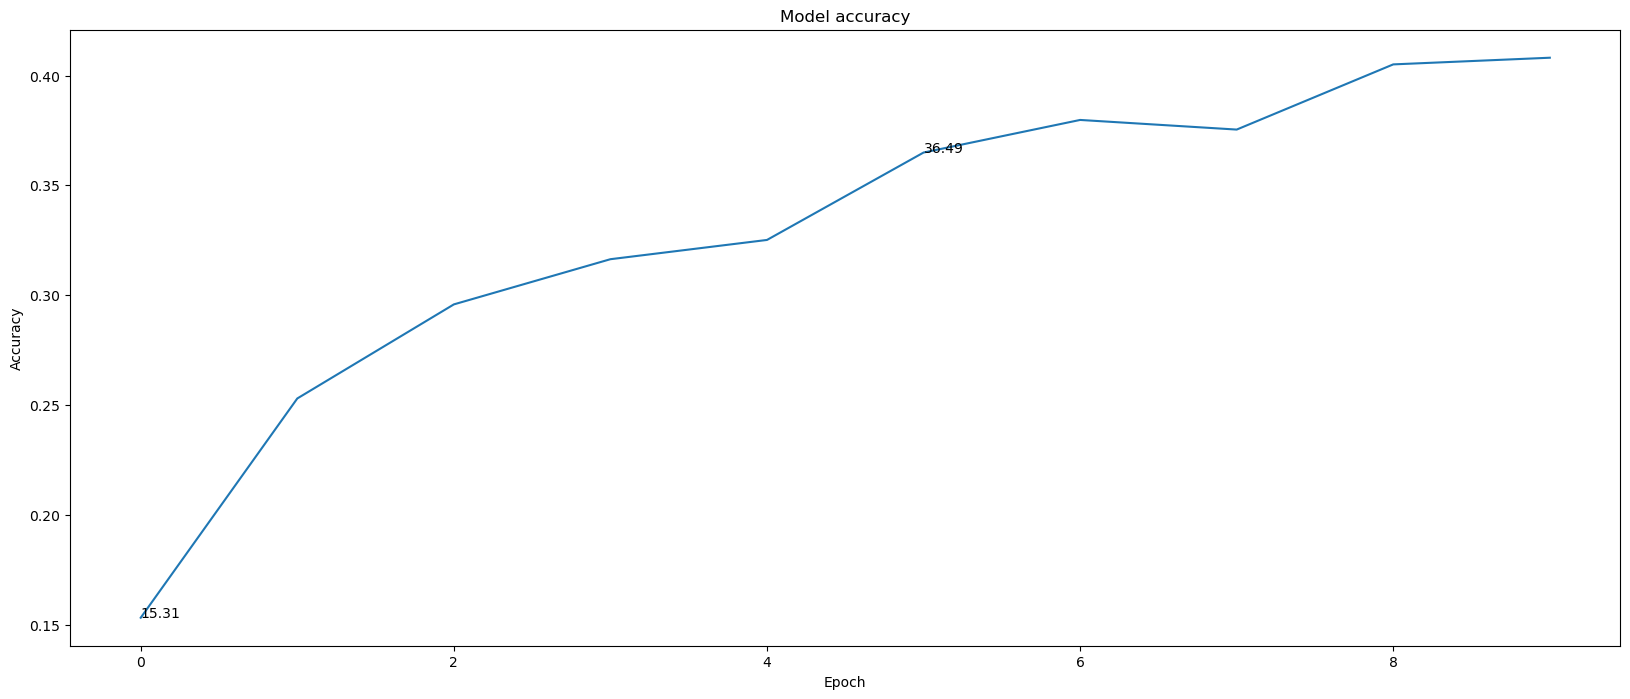

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

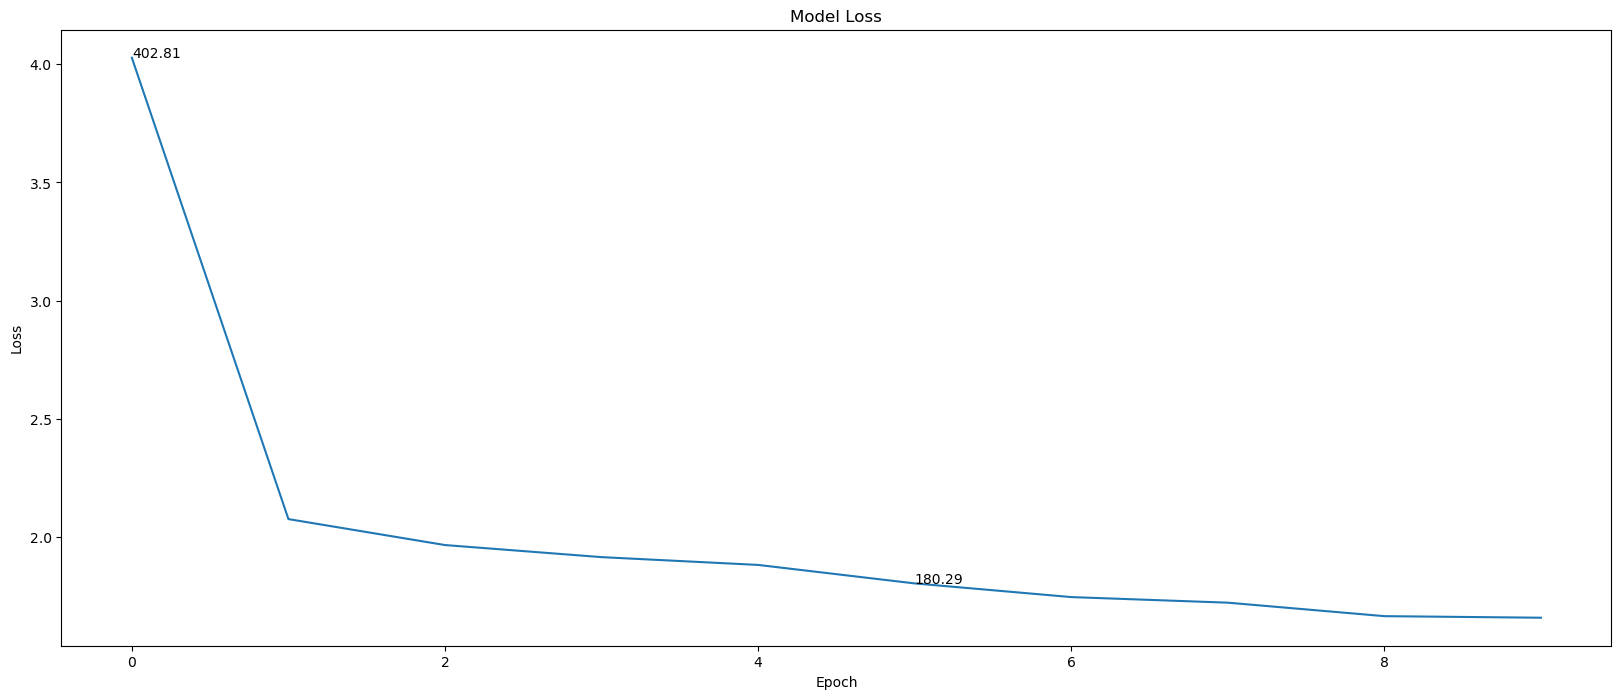

In [14]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()